In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import random 
import os 
import torch 
from torch import nn  
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split 
import time 
import datetime 
import json
import ccxt 
import sys

# Preprocess Data

In [2]:
with open('BTC_USDT-1h_bybit.json') as f: 
    df = json.load(f) 
    
df = pd.DataFrame(df) 
dates = df[0].values 

bybit = ccxt.bybit() 
timestamp = [] 
for i in range(len(dates)): 
    date_string = bybit.iso8601(int(dates[i]))  
    date_string = date_string[:10] + " " + date_string[11:-5] 
    timestamp.append(date_string) 
    
df['timestamp'] = timestamp
df['timestamp'] = pd.to_datetime(df['timestamp']) 

df['year'] = df['timestamp'].dt.year 
df['month'] = df['timestamp'].dt.month 
df['day'] = df['timestamp'].dt.day 
df['weekday'] = df['timestamp'].dt.weekday 
df['hour'] = df['timestamp'].dt.hour


df.head()

,0,1,2,3,4,5,timestamp,year,month,day,weekday,hour
0,1585130400000,6500.0,6591.5,6500.0,6591.5,2.636600e+01,2020-03-25 10:00:00,2020,3,25,2,10
1,1585134000000,6591.5,6628.5,6457.5,6511.5,2.857722e+06,2020-03-25 11:00:00,2020,3,25,2,11
2,1585137600000,6511.5,6588.5,6502.0,6583.5,3.484765e+06,2020-03-25 12:00:00,2020,3,25,2,12
3,1585141200000,6583.5,6745.5,6562.0,6585.0,2.957732e+06,2020-03-25 13:00:00,2020,3,25,2,13
4,1585144800000,6585.0,6640.0,6516.0,6590.0,1.705696e+06,2020-03-25 14:00:00,2020,3,25,2,14


In [3]:
df.to_csv("BTCUSDT_train.csv",index=False)

In [6]:
window_size = 20 
future_size = 1 
enc_inputs = [] 
dec_inputs = [] 
targets = [] 

for i in tqdm(range(df.shape[0] - window_size - future_size), position=0, leave=True):  
    ### get enc_inputs, dec_inputs and targets ### 
    o = df[1].values[i:i+window_size+future_size] 
    h = df[2].values[i:i+window_size+future_size] 
    l = df[3].values[i:i+window_size+future_size] 
    c = df[4].values[i:i+window_size+future_size] 
    v = df[5].values[i:i+window_size+future_size] 
    
    o = (o - np.min(o)) / (np.max(o) - np.min(o)) 
    h = (h - np.min(h)) / (np.max(h) - np.min(h)) 
    l = (l - np.min(l)) / (np.max(l) - np.min(l)) 
    c = (c - np.min(c)) / (np.max(c) - np.min(c)) 
    v = v / np.max(v)  
    
    o_train = o[:window_size].reshape((-1,1)) 
    o_target = o[-1].reshape((-1,1)) 
    h_train = h[:window_size].reshape((-1,1))
    h_target = h[-1].reshape((-1,1)) 
    l_train = l[:window_size].reshape((-1,1)) 
    l_target = l[-1].reshape((-1,1)) 
    c_train = c[:window_size].reshape((-1,1)) 
    c_target = c[-1].reshape((-1,1)) 
    v_train = v[:window_size].reshape((-1,1)) 
    v_target = v[-1].reshape((-1,1)) 
    
    x = np.concatenate([o_train,h_train,l_train,c_train,v_train],axis=1) 
    y = np.concatenate([o_target,h_target,l_target,c_target,v_target],axis=1)
    y0 = np.zeros([1, y.shape[1]]) # start of decoder inputs 

    enc_inputs.append(x) 
    dec_inputs.append(np.concatenate([y0, y], axis = 0)) 
    targets.append(y)  
    

100%|██████████| 13854/13854 [00:02<00:00, 6404.88it/s]


In [7]:
enc_inputs = np.array(enc_inputs)
dec_inputs = np.array(dec_inputs)
targets = np.array(targets) 

enc_inputs.shape, dec_inputs.shape, targets.shape

((13854, 20, 5), (13854, 2, 5), (13854, 1, 5))

# DataLoader

In [8]:
class CustomDataset(Dataset): 
    def __init__(self, encoder_input, decoder_input): 
        self.encoder_input = encoder_input 
        self.decoder_input = decoder_input 
    
    def __len__(self): 
        return len(self.encoder_input) 
    
    def __getitem__(self, i): 
        return {
            'encoder_input': torch.tensor(self.encoder_input[i], dtype=torch.float32), 
            'decoder_input': torch.tensor(self.decoder_input[i], dtype=torch.float32), 
        }

In [9]:
x_train, x_val, y_train, y_val = train_test_split(enc_inputs, dec_inputs, random_state = 888, test_size = 0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((12468, 20, 5), (1386, 20, 5), (12468, 2, 5), (1386, 2, 5))

In [10]:
BATCH_SIZE = 32 

train_dataset = CustomDataset(x_train, y_train)

val_dataset = CustomDataset(x_val, y_val) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

# Modeling

In [17]:
device = torch.device("cuda:0") # GPU 사용
target_n = 5 # number of features
learning_rate = 5e-4  
BATCH_SIZE = 32  
EPOCHS = 50 
teacher_forcing = True  
n_layers = 3 # number of GRU layers 
dropout = 0.2  
window_size = 20 # encoder sequence length 
future_size = 1 # decoder sequence length 
hidden_dim = 128 # rnn hidden dimension 
save_path = f'btc_seq2seq.pt' # model save path 

In [18]:
class Encoder(nn.Module): 
    def __init__(self, input_dim, hidden_dim, n_layers, dropout): 
        super().__init__() 
        self.n_layers = n_layers 
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, inp_seq): 
        inp_seq = inp_seq.permute(1,0,2) 
        outputs, hidden = self.rnn(inp_seq) 
        return outputs, hidden
    
class BahdanauAttention(nn.Module): 
    def __init__(self, dec_output_dim, units): 
        super(BahdanauAttention, self).__init__() 
        self.W1 = nn.Linear(dec_output_dim, units) 
        self.W2 = nn.Linear(dec_output_dim, units) 
        self.V = nn.Linear(dec_output_dim, 1) 
    
    def forward(self, hidden, enc_output): 
        query_with_time_axis = hidden.unsqueeze(1) 
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output))) 
        attention_weights = torch.softmax(score, axis=1) 
        context_vector = attention_weights * enc_output 
        context_vector = torch.sum(context_vector, dim = 1) 
        return context_vector, attention_weights

class Decoder(nn.Module): 
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__() 
        self.output_dim = output_dim 
        self.decoder_hidden_dim = decoder_hidden_dim 
        self.n_layers = n_layers 
        self.attention = attention 
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim) 
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout) 
        self.fc_out = nn.Linear(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(dropout) 
    
    def forward(self, enc_output, dec_input, hidden): 
        dec_input = self.layer(dec_input) 
        context_vector, attention_weight = self.attention(hidden, enc_output) 
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1) 
        dec_input = dec_input.unsqueeze(0) 
        output, hidden = self.rnn(dec_input, hidden) 
        prediction = self.fc_out(output.sum(0)) 
        return prediction, hidden

class Seq2Seq(nn.Module): 
    def __init__(self, encoder, decoder, attention): 
        super().__init__() 
        self.encoder = encoder
        self.decoder = decoder 
    
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1) 
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device) 
        enc_output, hidden = self.encoder(encoder_input) 
        dec_input = decoder_input[:,0] 
        for t in range(1, trg_len): 
            output, hidden = self.decoder(enc_output, dec_input, hidden) 
            outputs[:,t-1] = output
            if teacher_forcing == True: 
                dec_input = decoder_input[:,t] 
            else: 
                dec_input = output 
        
        return outputs

In [19]:
encoder = Encoder(input_dim = x_train.shape[-1], hidden_dim = hidden_dim, n_layers = n_layers, dropout=dropout) 
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim) 
decoder = Decoder(
    dec_feature_size = target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n, 
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, 
    attention=attention 
)

model = Seq2Seq(encoder, decoder, attention) 
model = model.cuda() 
model

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(5, 128, num_layers=3, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=128, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (V): Linear(in_features=128, out_features=1, bias=True)
    )
    (layer): Linear(in_features=5, out_features=128, bias=True)
    (rnn): GRU(256, 128, num_layers=3, dropout=0.2)
    (fc_out): Linear(in_features=128, out_features=5, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [21]:
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded)) 

In [26]:
model.zero_grad() 

# for reproducibility 
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_losses, val_losses = [], [] 

for epoch_i in range(0, EPOCHS): 
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')
    t0 = time.time() 
    total_loss = 0 
    model.train() 
    
    for step, batch in enumerate(train_dataloader):  
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('  current average loss = {}'.format(total_loss / step))
            
        encoder_input = batch['encoder_input'].to(device) 
        decoder_input = batch['decoder_input'].to(device) 
        
        with torch.cuda.amp.autocast(): 
            output = model(encoder_input, decoder_input, teacher_forcing) 
            loss = criterion(output, decoder_input[:,1:])
            total_loss += loss.item() 
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step() 
            # gradient initialization 
            model.zero_grad() 
    
    avg_train_loss = total_loss / len(train_dataloader)  
    train_losses.append(avg_train_loss)
    print("")
    print("  Average training loss: {}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        

    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")
    t0 = time.time() 
    model.eval() 
    eval_loss = 0 
    for batch in val_dataloader: 
        encoder_input = batch['encoder_input'].to(device) 
        decoder_input = batch['decoder_input'].to(device) 
                
        with torch.no_grad(): 
            outputs = model(encoder_input, decoder_input, False) 
            loss = criterion(outputs, decoder_input[:,1:]) 
            eval_loss += loss.item()  
        
    avg_val_loss = eval_loss / len(val_dataloader) 
    val_losses.append(avg_val_loss) 
    print("")
    print("  Average validation loss: {}".format(avg_val_loss))
    print("  Validation epoch took: {:}".format(format_time(time.time() - t0))) 
        
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint....")
        torch.save(model.state_dict(), "btc_seq2seq_" + str(epoch_i + 1) + "_val_loss_" + str(val_losses[-1])) 

        
        
print("")
print("Training Complete!")



======== Epoch 1 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.022511280328035354
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.021674601137638094
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.02150089164574941
  Batch   200  of    390.    Elapsed: 0:00:04.
  current average loss = 0.020981292063370346
  Batch   250  of    390.    Elapsed: 0:00:05.
  current average loss = 0.02086304534599185
  Batch   300  of    390.    Elapsed: 0:00:06.
  current average loss = 0.020794773205804327
  Batch   350  of    390.    Elapsed: 0:00:06.
  current average loss = 0.0204787445454193

  Average training loss: 0.020515684256903255
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.018599652494727212
  Validation epoch took: 0:00:00
Saving Best Checkpoint....

======== Epoch 2 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  curren

  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.016448071179911494
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.016282268936435383
  Batch   200  of    390.    Elapsed: 0:00:04.
  current average loss = 0.01657105950638652
  Batch   250  of    390.    Elapsed: 0:00:04.
  current average loss = 0.01661919583380222
  Batch   300  of    390.    Elapsed: 0:00:05.
  current average loss = 0.016668726736679674
  Batch   350  of    390.    Elapsed: 0:00:06.
  current average loss = 0.016448512175785645

  Average training loss: 0.016403778659132045
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.016962580107660455
  Validation epoch took: 0:00:00

======== Epoch 11 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.016483859699219464
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.01674206961877644
  Batch   150  of    390.    El

  Batch   250  of    390.    Elapsed: 0:00:05.
  current average loss = 0.014722200311720371
  Batch   300  of    390.    Elapsed: 0:00:06.
  current average loss = 0.01468475386655579
  Batch   350  of    390.    Elapsed: 0:00:07.
  current average loss = 0.014742293384458337

  Average training loss: 0.01492845216431679
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.01555468266914514
  Validation epoch took: 0:00:00

======== Epoch 20 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.014320888062939048
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.014591908203437925
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.014485624749213458
  Batch   200  of    390.    Elapsed: 0:00:04.
  current average loss = 0.01465169038856402
  Batch   250  of    390.    Elapsed: 0:00:04.
  current average loss = 0.014681410796940327
  Batch   300  of    390.    Ela

  Batch   300  of    390.    Elapsed: 0:00:06.
  current average loss = 0.013078952527915438
  Batch   350  of    390.    Elapsed: 0:00:07.
  current average loss = 0.013137614652514458

  Average training loss: 0.013111354605270884
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.013592949327589436
  Validation epoch took: 0:00:00

======== Epoch 29 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.011275946851819754
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.012124391058459878
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.012243074715758364
  Batch   200  of    390.    Elapsed: 0:00:04.
  current average loss = 0.012600341027136893
  Batch   250  of    390.    Elapsed: 0:00:04.
  current average loss = 0.012876399556174874
  Batch   300  of    390.    Elapsed: 0:00:05.
  current average loss = 0.012746006998543937
  Batch   350  of    390.   

  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.01080065525136888
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.011148237730376423
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.011264759721234441
  Batch   200  of    390.    Elapsed: 0:00:03.
  current average loss = 0.011234771539457143
  Batch   250  of    390.    Elapsed: 0:00:04.
  current average loss = 0.011230841783806681
  Batch   300  of    390.    Elapsed: 0:00:05.
  current average loss = 0.01112517926686754
  Batch   350  of    390.    Elapsed: 0:00:06.
  current average loss = 0.011120981486248118

  Average training loss: 0.011223424120973317
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.013542738266881894
  Validation epoch took: 0:00:00

======== Epoch 39 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.011103529687970877
  Batch   100  of    390.    E

  Batch   250  of    390.    Elapsed: 0:00:05.
  current average loss = 0.009475310981273652
  Batch   300  of    390.    Elapsed: 0:00:06.
  current average loss = 0.009379148807687063
  Batch   350  of    390.    Elapsed: 0:00:06.
  current average loss = 0.009542875345796347

  Average training loss: 0.009552275012127864
  Training epoch took: 0:00:07

Running Validation...

  Average validation loss: 0.013726661585017362
  Validation epoch took: 0:00:00

======== Epoch 48 / 50 ========
Training...
  Batch    50  of    390.    Elapsed: 0:00:01.
  current average loss = 0.008819781262427568
  Batch   100  of    390.    Elapsed: 0:00:02.
  current average loss = 0.009053702326491475
  Batch   150  of    390.    Elapsed: 0:00:03.
  current average loss = 0.009152800412848591
  Batch   200  of    390.    Elapsed: 0:00:04.
  current average loss = 0.009103793017566204
  Batch   250  of    390.    Elapsed: 0:00:04.
  current average loss = 0.009087019486352802
  Batch   300  of    390.   

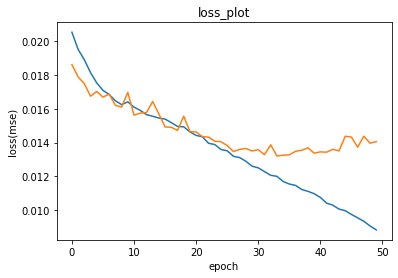

In [37]:
plt.plot(train_losses, label='train_loss') 
plt.plot(val_losses, label='val_loss') 
plt.xlabel('epoch') 
plt.ylabel('loss(mse)') 
plt.title('loss_plot') 

plt.show() 

# Inference

In [32]:
test = pd.read_csv("test_data.csv") 
test.head() 

,0,1,2,3,4,5,timestamp
0,1635109200000,61186.0,61343.0,60852.0,61009.5,8.998808e+07,2021-10-24 21:00:00
1,1635112800000,61009.5,61103.5,60860.0,60957.5,3.615479e+07,2021-10-24 22:00:00
2,1635116400000,60957.5,60995.5,60752.0,60901.5,4.064861e+07,2021-10-24 23:00:00
3,1635120000000,60901.5,61840.0,60708.5,61827.5,1.381452e+08,2021-10-25 00:00:00
4,1635123600000,61827.5,62145.5,61730.0,61746.0,1.034869e+08,2021-10-25 01:00:00


In [39]:
window_size = 20 
future_size = 1 
test_enc_inputs = [] 
test_dec_inputs = [] 
test_targets = [] 

for i in tqdm(range(test.shape[0] - window_size - future_size), position=0, leave=True):  
    ### get enc_inputs, dec_inputs and targets ### 
    o = test.iloc[:,1].values[i:i+window_size+future_size] 
    h = test.iloc[:,2].values[i:i+window_size+future_size] 
    l = test.iloc[:,3].values[i:i+window_size+future_size] 
    c = test.iloc[:,4].values[i:i+window_size+future_size] 
    v = test.iloc[:,5].values[i:i+window_size+future_size] 
    
    o = (o - np.min(o)) / (np.max(o) - np.min(o)) 
    h = (h - np.min(h)) / (np.max(h) - np.min(h)) 
    l = (l - np.min(l)) / (np.max(l) - np.min(l)) 
    c = (c - np.min(c)) / (np.max(c) - np.min(c)) 
    v = v / np.max(v)  
    
    o_train = o[:window_size].reshape((-1,1)) 
    o_target = o[-1].reshape((-1,1)) 
    h_train = h[:window_size].reshape((-1,1))
    h_target = h[-1].reshape((-1,1)) 
    l_train = l[:window_size].reshape((-1,1)) 
    l_target = l[-1].reshape((-1,1)) 
    c_train = c[:window_size].reshape((-1,1)) 
    c_target = c[-1].reshape((-1,1)) 
    v_train = v[:window_size].reshape((-1,1)) 
    v_target = v[-1].reshape((-1,1)) 
    
    x = np.concatenate([o_train,h_train,l_train,c_train,v_train],axis=1) 
    y = np.concatenate([o_target,h_target,l_target,c_target,v_target],axis=1)
    
    test_enc_inputs.append(x) 
    test_dec_inputs.append(np.zeros([future_size+1,target_n])) 
    test_targets.append(y)
    
test_enc_inputs = np.array(test_enc_inputs) 
test_dec_inputs = np.array(test_dec_inputs)  
test_targets = np.array(test_targets)

test_enc_inputs.shape, test_dec_inputs.shape, test_targets.shape

100%|██████████| 59/59 [00:00<00:00, 2121.93it/s]


((59, 20, 5), (59, 2, 5), (59, 1, 5))

In [52]:
checkpoint = torch.load('btc_seq2seq_34_val_loss_0.013208275724371726') 
test_model = Seq2Seq(encoder, decoder, attention)  
test_model.load_state_dict(checkpoint) 
test_model.cuda() 
test_model.eval() # change to eval mode 

test_loss = 0 
correct = 0 
total_cnt = 0 
eps = 1e-10
for i in range(len(test_enc_inputs)): 
    encoder_input = torch.tensor(test_enc_inputs[i], dtype=torch.float32).to(device) 
    decoder_input = torch.tensor(test_dec_inputs[i], dtype=torch.float32).to(device) 
    test_target = torch.tensor(test_targets[i], dtype=torch.float32).to(device)  
    
    encoder_input = torch.reshape(encoder_input, (1,20,5)) 
    decoder_input = torch.reshape(decoder_input, (1,2,5)) 
    test_target = torch.reshape(test_target, (1,1,5)) 
    
    with torch.no_grad():
        outputs = test_model(encoder_input, decoder_input, False)
        loss = criterion(outputs, test_target)
        test_loss += loss.item() 
        pred_y = outputs.detach().cpu().numpy()[:,:,0]
        previous_y = encoder_input.detach().cpu().numpy()[:,-1,0].reshape((-1,1)) 
        actual_y = test_target.detach().cpu().numpy()[:,:,0]
        
        for i in range(len(pred_y)): 
            if pred_y[i] >= previous_y[i] and actual_y[i] >= previous_y[i]: 
                correct += 1 
            elif pred_y[i] < previous_y[i] and actual_y[i] < previous_y[i]: 
                correct += 1 
            total_cnt += 1  
            

print("total loss = {:.4f}".format(test_loss)) 
print("correct = {}/{}".format(correct, total_cnt))  
print("accuracy = {:.4f}%".format(correct * 100 / total_cnt))

total loss = 0.7768
correct = 53/59
accuracy = 89.8305%
